# Retail ML Project
Problem statement:
- It is a business critical requirement to understand the value derived from a customer. RFM is a method used for analyzing customer value.
- Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value). 
- Identifying the most valuable RFM segments can capitalize on chance relationships in the data used for this analysis.


Objectives:
- Data Cleaning
- Data Transformation
- Data Modeling


Data Description:
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
-Quantity: The quantities of each product (item) per transaction. Numeric. 
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated. 
- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal, the name of the country where each customer resides.


## Data Cleaning
- Insepect the data and understand it 
- Clean the data to improve quality

### Inspecting the data

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pip install openpyxl
import openpyxl

In [49]:
# Step 0 - Open the excel file and read the descriptions
# Load the dataset and check it 
df = pd.read_excel("./datasets/Online Retail.xlsx")

In [50]:
# 379336 rows and 8 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Cleaning the data
- Drop duplicates
- Check for NaN
- Format the data
- Check for unreasonable values

In [51]:
# Drop duplicates
df = df.drop_duplicates()

In [52]:
# df.isnull().sum() # Also works since there are little columns
# First find the column names that have missing data
empty_cols = df.columns[df.isna().any()].tolist()

# Add the number of missing data next to the column name
for x, i in enumerate(empty_cols):
    if i in df.columns:
        empty_cols[x] = empty_cols[x] + f" {df[i].isnull().sum()}"
print(empty_cols)


['Description 1454', 'CustomerID 135037']


NLP will not be used in this model. Hence, the description column can be safely dropped.

On the other hand, missing customer id cannot be averaged and must have the row dropped.

In [53]:
df = df.dropna()
df = df.drop(["Description"], axis=1)
df.shape

(401604, 7)

In [54]:
# Convert CustomerID to a string
df["CustomerID"] = df["CustomerID"].astype(int).astype(str)

In [55]:
df

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...
541904,581587,22613,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,4,2011-12-09 12:50:00,4.15,12680,France


In [56]:
# Check if the numeric columns have any sketchy numbers
for col in df.columns:
    if df[col].dtype in ["int64", "float64", "int32", "int16", "float32"]:
        if (df[col] < 0).any():
            print(f"Column {col} has negative numbers")
        elif (df[col] == 0).any():
            print(f"Column {col} has 0s")

Column Quantity has negative numbers
Column UnitPrice has 0s


In [57]:
# Unit price cannot be 0, and discounts usually avoid such exploits.
len(df[df["UnitPrice"]==0]), len(df[df["Quantity"]<0])

(40, 8872)

In [58]:
df = df[df["Quantity"] >= 0]
df = df[df["UnitPrice"] > 0]
df.shape

(392692, 7)

## Data Transformation
- Create monthly cohorts to analyze active customers
- Analyze the retention rate of customers

In [59]:
# Add a new column that indicates the month only
# Add another column for the date without the time
df["month_year"] = df.InvoiceDate.dt.to_period("M")
df["purchase_date"] = df["InvoiceDate"].dt.to_period("D")
df["month_year"].unique()

<PeriodArray>
['2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
 '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12']
Length: 13, dtype: period[M]

In [60]:
# Find the monthly unique active users
monthly_customers = df.groupby("month_year")["CustomerID"].nunique()
monthly_customers

month_year
2010-12     885
2011-01     741
2011-02     758
2011-03     974
2011-04     856
2011-05    1056
2011-06     991
2011-07     949
2011-08     935
2011-09    1266
2011-10    1364
2011-11    1664
2011-12     615
Freq: M, Name: CustomerID, dtype: int64

Text(0.5, 0, 'Number of unique active users')

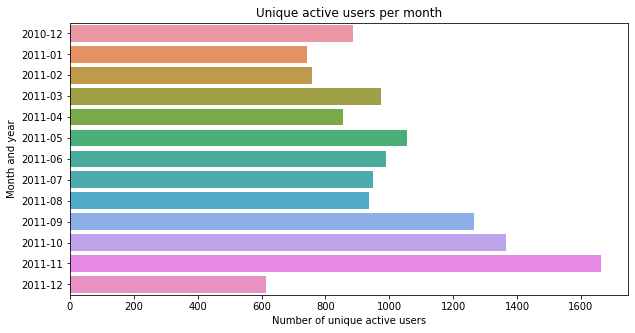

In [61]:
plt.figure(figsize=(10, 5))
sns.barplot(y=monthly_customers.index, x=monthly_customers.values)
plt.title("Unique active users per month")
plt.ylabel("Month and year")
plt.xlabel("Number of unique active users")

In [62]:
# Find the % change from the previous row
retention_rate = round(monthly_customers.pct_change(1)*100,2)

<AxesSubplot:ylabel='month_year'>

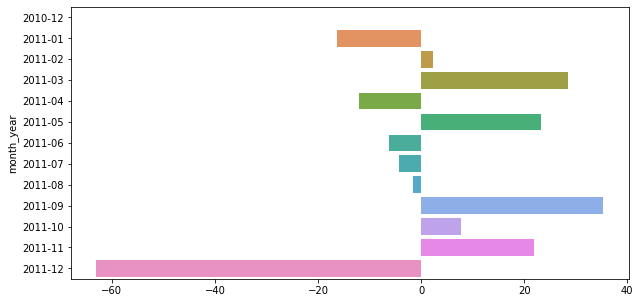

In [63]:
plt.figure(figsize=(10, 5))
sns.barplot(x=retention_rate.values, y= retention_rate.index)

It is clear that the retention rate of the company is poor. 

The retention rate may also be seasonal considering how the highest spikes in customer retention occurs during the months closer to thanksgiving and christmas.

## Data Modeling
- Build an RFM model
- Calculate RFM metrics
- Build RFM segments

### Building an RFM model

In [64]:
# The latest data has dates up to 2011-12-09
# The reference date will be the day after 2011-12-10
df["purchase_date"].max()

Period('2011-12-09', 'D')

In [65]:
# Note that the purchase date was previously stored as a period object
# It is converted to a timestamp in the new data frame for conviencence
reference_date = pd.to_datetime("2011-12-10")
df_recency = df.groupby("CustomerID", as_index=False)["purchase_date"].max()
df_recency = df_recency.rename(columns={"CustomerID":"Customer ID"})
df_recency.index = df_recency.index + 1
df_recency["Recency"] = df_recency["purchase_date"].apply(lambda row: (reference_date - row.to_timestamp()).days)
df_recency.drop("purchase_date", axis=1, inplace=True)
df_recency

,Customer ID,Recency
1,12346,326
2,12347,3
3,12348,76
4,12349,19
5,12350,311
...,...,...
4334,18280,278
4335,18281,181
4336,18282,8
4337,18283,4


In [66]:
# The frequency will be over the whole data set, since it spans 1 year only
# Group the data according to customer ID then count the number of Inovoices
df_frequency = df.groupby("CustomerID", as_index=False)["InvoiceNo"].count()
df_frequency.index = df_frequency.index + 1
df_frequency.rename(columns={"CustomerID":"Customer ID", "InvoiceNo":"Frequency"}, inplace=True)
df_frequency

,Customer ID,Frequency
1,12346,1
2,12347,182
3,12348,31
4,12349,73
5,12350,17
...,...,...
4334,18280,10
4335,18281,7
4336,18282,12
4337,18283,721


In [67]:
# Calculate the money spent by the customer over the period selected
# In this case over 1 year (13 months in reality)
df["total_sale"] = df.UnitPrice * df.Quantity
df_monetary = df.groupby("CustomerID", as_index=False)["total_sale"].sum()
df_monetary.index = df_monetary.index + 1
df_monetary.rename(columns={"CustomerID":"Customer ID", "total_sale":"Monetary"}, inplace=True)
df_monetary

,Customer ID,Monetary
1,12346,77183.60
2,12347,4310.00
3,12348,1797.24
4,12349,1757.55
5,12350,334.40
...,...,...
4334,18280,180.60
4335,18281,80.82
4336,18282,178.05
4337,18283,2045.53


In [68]:
# Final RFM Table
rfm_df = df_recency.merge(df_frequency, on='Customer ID')
rfm_df = rfm_df.merge(df_monetary, on="Customer ID")
rfm_df.index = rfm_df.index + 1
rfm_df

,Customer ID,Recency,Frequency,Monetary
1,12346,326,1,77183.60
2,12347,3,182,4310.00
3,12348,76,31,1797.24
4,12349,19,73,1757.55
5,12350,311,17,334.40
...,...,...,...,...
4334,18280,278,10,180.60
4335,18281,181,7,80.82
4336,18282,8,12,178.05
4337,18283,4,721,2045.53


### Calculating the RFM score

In [69]:

# The results must now be normalized in order to rank the customer
# Recency is better when lower, hence the lower the score the higher the rank
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['M_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head()

,Customer ID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
1,12346,326,1,77183.60,3.760704,0.829876,99.792531
2,12347,3,182,4310.00,96.169868,88.231904,92.300599
3,12348,76,31,1797.24,38.093034,42.346704,76.878746
4,12349,19,73,1757.55,74.276788,67.093130,76.348548
5,12350,311,17,334.40,5.264985,24.953896,28.630705


In [70]:

# Different weights will be given for each rank
# Recency receives least, while monetary receives the most
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm'] + 0.28* \
    rfm_df['F_rank_norm'] + 0.57*rfm_df['M_rank_norm']

# The RFM score will be out of 10 and consist of 2 decimal places
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['Customer ID', 'RFM_Score']].sort_values(by=["RFM_Score"], ascending=False)

,Customer ID,RFM_Score
1880,14911,4.99
2177,15311,4.99
1690,14646,4.99
327,12748,4.98
4011,17841,4.97
...,...,...
3241,16765,0.07
3218,16738,0.06
2639,15940,0.06
1641,14576,0.03


### RFM Segmentation

Newest        2681
Recent         616
Occasional     415
Seasonal       356
Lost           270
Name: recency_labels, dtype: int64

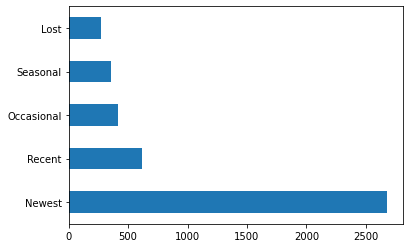

In [71]:
rfm_segs = pd.DataFrame()
rfm_segs["recency_labels"] = pd.cut(rfm_df["Recency"], bins=5, 
    labels=["Newest", "Recent", "Occasional", "Seasonal", "Lost"])
rfm_segs["recency_labels"].value_counts().plot(kind="barh");
rfm_segs["recency_labels"].value_counts()

Least frequent    4328
Less frequent        6
More frequent        2
Frequent             1
Most frequent        1
Name: frequency_labels, dtype: int64

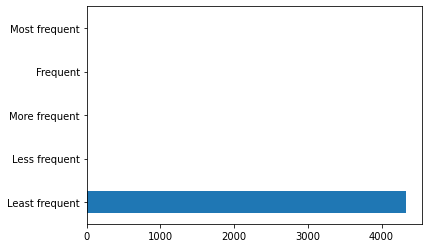

In [72]:
rfm_segs["frequency_labels"] = pd.cut(rfm_df["Frequency"], bins=5, 
    labels=["Least frequent", "Less frequent", "Frequent", "More frequent", "Most frequent"])
rfm_segs["frequency_labels"].value_counts().plot(kind="barh");
rfm_segs["frequency_labels"].value_counts()

Least spender      4321
Low spender          10
Average spender       3
High spender          2
Top spender           2
Name: monetary_labels, dtype: int64

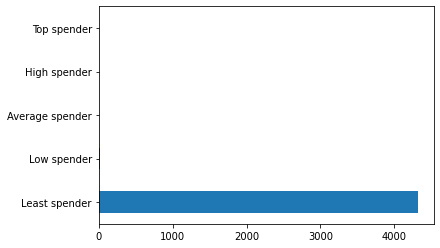

In [73]:
rfm_segs["monetary_labels"] = pd.cut(rfm_df["Monetary"], bins=5, 
    labels=["Least spender", "Low spender", "Average spender", "High spender", "Top spender"])
rfm_segs["monetary_labels"].value_counts().plot(kind="barh");
rfm_segs["monetary_labels"].value_counts()

In [74]:
rfm_df["Segmentation"] = rfm_segs["recency_labels"].astype(str) + "-" + rfm_segs["frequency_labels"].astype(str) \
    + "-" + rfm_segs["monetary_labels"].astype(str)
rfm_df

,Customer ID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Segmentation
1,12346,326,1,77183.60,3.76,0.83,99.79,2.88,Lost-Least frequent-Low spender
2,12347,3,182,4310.00,96.17,88.23,92.30,4.59,Newest-Least frequent-Least spender
3,12348,76,31,1797.24,38.09,42.35,76.88,3.07,Recent-Least frequent-Least spender
4,12349,19,73,1757.55,74.28,67.09,76.35,3.67,Newest-Least frequent-Least spender
5,12350,311,17,334.40,5.26,24.95,28.63,1.20,Lost-Least frequent-Least spender
...,...,...,...,...,...,...,...,...,...
4334,18280,278,10,180.60,8.22,14.33,13.16,0.64,Seasonal-Least frequent-Least spender
4335,18281,181,7,80.82,19.90,9.36,2.40,0.35,Occasional-Least frequent-Least spender
4336,18282,8,12,178.05,88.83,17.70,12.70,1.28,Newest-Least frequent-Least spender
4337,18283,4,721,2045.53,94.04,99.30,79.88,4.37,Newest-Least frequent-Least spender


Newest-Least frequent-Least spender        2660
Recent-Least frequent-Least spender         616
Occasional-Least frequent-Least spender     415
Seasonal-Least frequent-Least spender       356
Lost-Least frequent-Least spender           269
Newest-Least frequent-Low spender             6
Newest-Less frequent-Least spender            3
Newest-Less frequent-Low spender              2
Newest-Least frequent-Average spender         2
Newest-Least frequent-High spender            2
Newest-More frequent-Average spender          1
Newest-Most frequent-Least spender            1
Lost-Least frequent-Low spender               1
Newest-Less frequent-Top spender              1
Newest-More frequent-Low spender              1
Newest-Frequent-Least spender                 1
Newest-Least frequent-Top spender             1
Name: Segmentation, dtype: int64

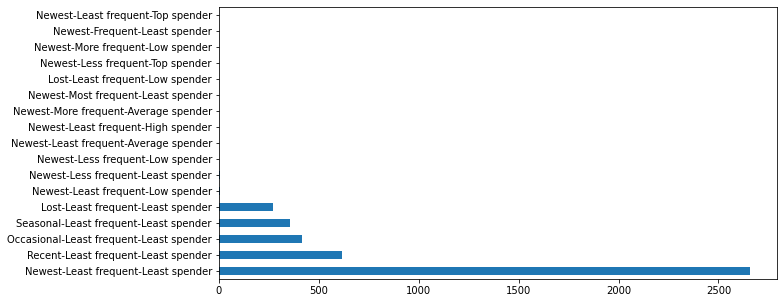

In [75]:
plt.figure(figsize=(10, 5))
rfm_df["Segmentation"].value_counts().plot(kind="barh");
rfm_df["Segmentation"].value_counts()

## Data Modeling
- Check the distribution of data 
- Prepare the data (remove outliers if necessary and standardize)
- Use k-means clustering 

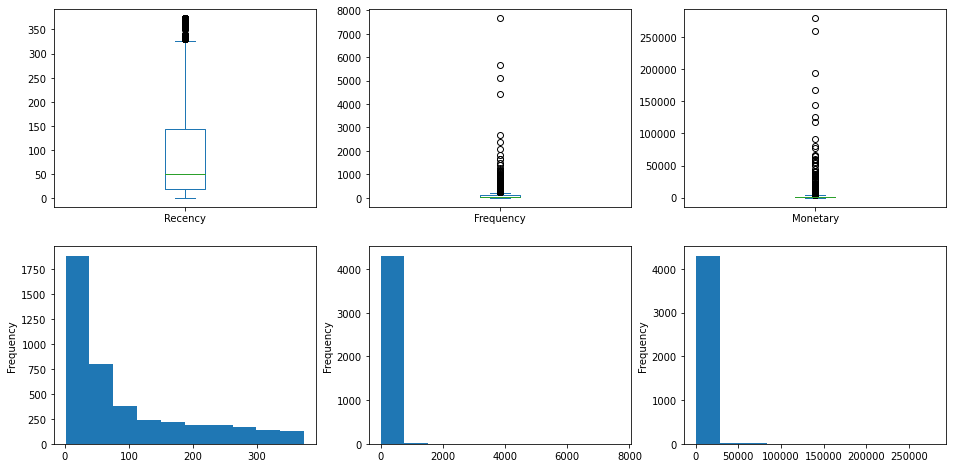

In [76]:
# Plot each of the RFM metrics to gain insight
plt.subplots(2, 3, figsize=(16,8))
for i, metric in enumerate(["Recency", "Frequency", "Monetary"]):
    plt.subplot(2, 3, i+1)
    rfm_df[metric].plot(kind="box")
    plt.subplot(2, 3, i+4)
    rfm_df[metric].plot(kind="hist")

It can be seen that recency has a lot of outliers. I constrast, frequency has the least, while maintaining varying degrees of outliers. Finally, monetary illustrates both the highest and most extreme outliers.

As for the frequencies, all 3 features appear to be right-skewed.

In [77]:
# Create a log transformed dataframe in order to get
# more normally distributed data
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
rfm_log = pd.DataFrame(pt.fit_transform(rfm_df[["Recency", "Frequency", "Monetary"]]))
rfm_log.columns = ["Recency", "Frequency", "Monetary"]
rfm_log.head(7)

,Recency,Frequency,Monetary
0,1.614069,-2.427939,3.124061
1,-1.729209,1.189871,1.378940
2,0.306988,-0.213464,0.755356
3,-0.715181,0.460181,0.738795
4,1.567794,-0.674706,-0.587198
5,-0.250039,0.581141,0.998074
6,1.170349,-1.698374,-1.788356


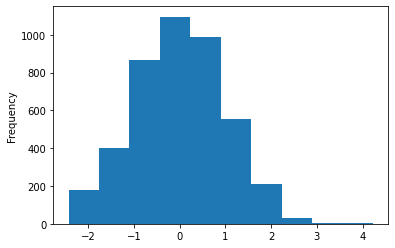

In [78]:
# The data is now more normally distributed and is ready to be clustered
rfm_log["Frequency"].plot(kind="hist");

### Building the K-means Clustering Model

Text(0, 0.5, 'Loss')

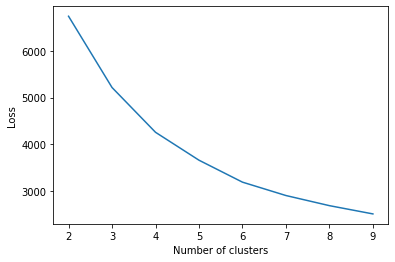

In [109]:
# First find the Optimal Number of Clusters 
from sklearn.cluster import KMeans

loss = []
n_clusters = []
for cluster in range(2, 10):
    kmeans = KMeans(n_clusters=cluster, max_iter=200)
    kmeans.fit(rfm_log)

    loss.append(kmeans.inertia_)
    n_clusters.append(cluster)

# Plot the loss curve
plt.plot(n_clusters, loss);
plt.xlabel("Number of clusters")
plt.ylabel("Loss")

The silhouette method shall be utulized, since the elbow is not clear on the graph

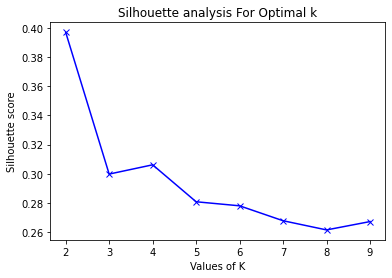

In [110]:
from sklearn.metrics import silhouette_score
n_clusters = []
silhouette_avg = []
for cluster in range(2, 10):
    # initialise kmeans
    kmeans = KMeans(n_clusters=cluster, max_iter=200)
    kmeans.fit(rfm_log)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(rfm_log, cluster_labels))
    n_clusters.append(cluster)
plt.plot(n_clusters,silhouette_avg,'bx-')
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In the loss curve the elbow of the curve was unclear between 3 and 4 clusters.

However, using the silhouette analysis method 4 clusters appear to be the optimal amount of clusters.

Notably, the analysis indicates 2 as the optimal classifiction. However, the case would be trivial since as the data showed previously the data is vastly right-skewed.

In [111]:
kmeans = KMeans(n_clusters=4, max_iter=200)
kmeans.fit(rfm_log)

KMeans(max_iter=200, n_clusters=4)

In [112]:
rfm_df["Cluster_Id"] = kmeans.labels_
rfm_df.head()

,Customer ID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Segmentation,Cluster_Id
1,12346,326,1,77183.60,3.76,0.83,99.79,2.88,Lost-Least frequent-Low spender,2
2,12347,3,182,4310.00,96.17,88.23,92.30,4.59,Newest-Least frequent-Least spender,1
3,12348,76,31,1797.24,38.09,42.35,76.88,3.07,Recent-Least frequent-Least spender,2
4,12349,19,73,1757.55,74.28,67.09,76.35,3.67,Newest-Least frequent-Least spender,1
5,12350,311,17,334.40,5.26,24.95,28.63,1.20,Lost-Least frequent-Least spender,0


### Visualize the data according to each criteria of RFM

,Cluster_Id,count
0,0,1116
1,1,1102
2,2,1156
3,3,964


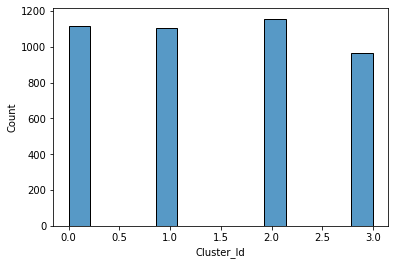

In [113]:
# Checking the distribution of clusters
# The clusters appear to be mostly evenly distributed
sns.histplot(rfm_df["Cluster_Id"]);
rfm_df.groupby("Cluster_Id", as_index=False)["Cluster_Id"].value_counts()

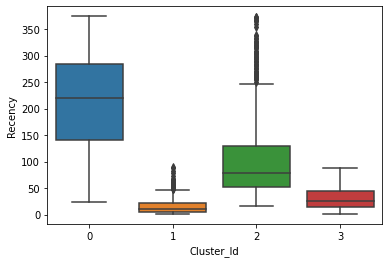

In [114]:
# Plotting Recency vs Cluster Id
sns.boxplot(x="Cluster_Id", y="Recency", data=rfm_df);

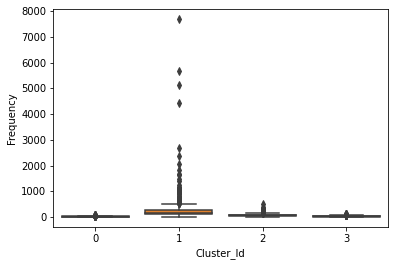

In [115]:
# Plotting Frequency vs Cluster Id
sns.boxplot(x="Cluster_Id", y="Frequency", data=rfm_df);

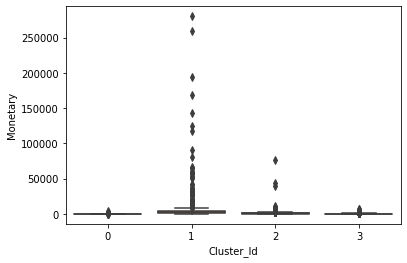

In [116]:
# Plotting Monetary vs Cluster Id
sns.boxplot(x="Cluster_Id", y="Monetary", data=rfm_df);

### Conclusions: 
- CLuster 0: Consists of low to mid range spending customers, which are mostly occasional buyer that buy less frequently
- Cluster 1: Consists of least spenders, which range from ocassional customers to lost customers and shop the least frequent
- Cluster 2: Similar to cluster two. However, their purchases are significantly more recent.
- Cluster 3: Consists of people who spend average and above. Their frequency ranges mainly from occassional to most frequent and are typically have their next purchase under 100 days.

In essence, the company should focus on clusters 1, 2 and 3.
- Cluster 1 illustrates top customers who are already hooked to the brand. They must be handled with care and urgency in order to retain them and encourage further bussiness with them.
- Cluster 3 highlights people who are loyal to the brand or newly exposed to the brand. In both cases, the chances of retaining them is much more likely than clusters 0 and 1.
- 

## Exporting the excel File for Creating a Tableau Dashboard

In [118]:
rfm_df

,Customer ID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Segmentation,Cluster_Id
1,12346,326,1,77183.60,3.76,0.83,99.79,2.88,Lost-Least frequent-Low spender,2
2,12347,3,182,4310.00,96.17,88.23,92.30,4.59,Newest-Least frequent-Least spender,1
3,12348,76,31,1797.24,38.09,42.35,76.88,3.07,Recent-Least frequent-Least spender,2
4,12349,19,73,1757.55,74.28,67.09,76.35,3.67,Newest-Least frequent-Least spender,1
5,12350,311,17,334.40,5.26,24.95,28.63,1.20,Lost-Least frequent-Least spender,0
...,...,...,...,...,...,...,...,...,...,...
4334,18280,278,10,180.60,8.22,14.33,13.16,0.64,Seasonal-Least frequent-Least spender,0
4335,18281,181,7,80.82,19.90,9.36,2.40,0.35,Occasional-Least frequent-Least spender,0
4336,18282,8,12,178.05,88.83,17.70,12.70,1.28,Newest-Least frequent-Least spender,3
4337,18283,4,721,2045.53,94.04,99.30,79.88,4.37,Newest-Least frequent-Least spender,1


In [120]:
# Writing dataframe to excel file for creating visualization in tableau
writer = pd.ExcelWriter('./output_data.xlsx', engine='xlsxwriter')

df.to_excel(writer, sheet_name='master_data', index=False)
rfm_df.to_excel(writer, sheet_name='rfm_data', index=False)
writer.save()

In [121]:
product_desc = pd.read_excel("./datasets/Online Retail.xlsx")
product_desc = product_desc[['StockCode', 'Description']]
product_desc = product_desc.drop_duplicates()
product_desc.to_csv('product_desc.csv', index=False)